In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib
import os
import matplotlib.pyplot as plt
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


1. 인물모드 사진을 성공적으로 제작하였다.

아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.

인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.

Step 1. 인물모드 직접 해 보기
-----
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환- 상적인 사진을 만들어 보면 어떨까요?

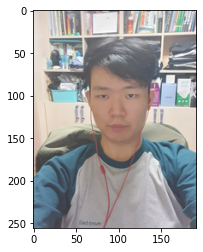

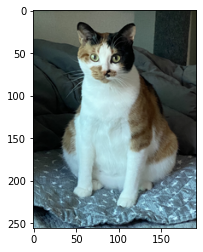

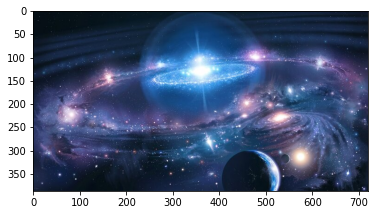

In [2]:
img_path = os.getenv("HOME") + "/aiffel/human_segmentation/images"

img_person_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/myimage2.png"

img_cat_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/deoksun2.png"

img_person = cv2.imread(img_path+'/myimage2.png')
img_cat = cv2.imread(img_path+'/deoksun2.png')
img_bg = cv2.imread(img_path+'/space.png')

img_cat = cv2.rotate(img_cat, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(cv2.cvtColor(img_person,cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_cat,cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_bg,cv2.COLOR_BGR2RGB))
plt.show()




segmentation 모델을 가져오자!

In [3]:
model_dir=os.getenv("HOME") + '/aiffel/human_segmentation/models'

model_file=os.path.join(model_dir , 'deeplabv3_xception_tf_dim_ordering_tf_kernels_h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)


('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels_h5',
 <http.client.HTTPMessage at 0x7f6e58106430>)

In [4]:
model = semantic_segmentation() #semantic segmentation을 모델로 삼는다.
model.load_pascalvoc_model(model_file) #

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_person_path)

In [6]:
#선아님 고양이 덕순이가지고 segmentation하기
model2 = semantic_segmentation()
model2.load_pascalvoc_model(model_file)
segvalues_cat, output_cat = model2.segmentAsPascalvoc(img_cat_path)

In [7]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [8]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
sofa


In [9]:
for class_id in segvalues_cat['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
person


In [10]:
segvalues_cat

{'class_ids': array([ 0,  8, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [11]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
seg_color = (128,128,192)
seg_color_cat = (0,0,64)

(256, 192)


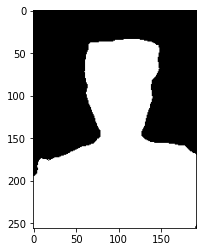

(192, 256)


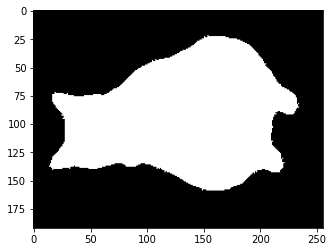

In [21]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함

seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

seg_map_cat = np.all(output_cat==seg_color_cat, axis=-1)
print(seg_map_cat.shape)
plt.imshow(seg_map_cat, cmap='gray')
plt.show()


In [29]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_person.copy()
print(img_show.shape)
#True와 False인값을 각각 255,0으로 바꿔주자
img_mask = seg_map.astype(np.uint8) * 255
print(img_mask.shape)
# 255와 0을 적당한 색상으로 바꿔줍니다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
print(color_mask.shape)

(256, 192, 3)
(256, 192)
(256, 192, 3)


In [33]:
img_cat_show = img_cat.copy()
print(img_cat_show.shape)
img_cat_mask = seg_map_cat.astype(np.uint8) * 255
img_cat_mask = cv2.rotate(img_cat_mask, cv2.ROTATE_90_CLOCKWISE)
print(img_cat_mask.shape)
color_cat_mask = cv2.applyColorMap(img_cat_mask, cv2.COLORMAP_JET)
print(color_cat_mask.shape)

(256, 192, 3)
(256, 192)
(256, 192, 3)


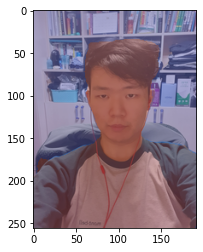

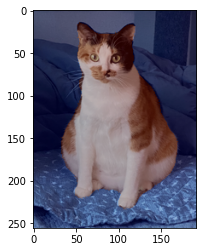

In [34]:
img_show = cv2.addWeighted(img_show, 0.7, color_mask, 0.3, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_cat_show = cv2.addWeighted(img_cat_show, 0.7, color_cat_mask, 0.3, 0.0)
plt.imshow(cv2.cvtColor(img_cat_show, cv2.COLOR_BGR2RGB))
plt.show()

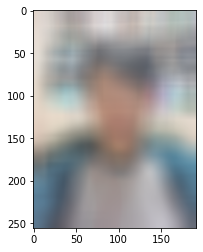

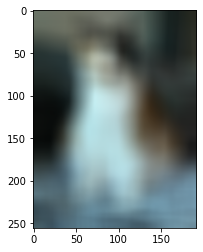

In [36]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_person, (30,30))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_cat_orig_blur = cv2.blur(img_cat, (30,30))

plt.imshow(cv2.cvtColor(img_cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

Step 2. 사진에서 문제점 찾기

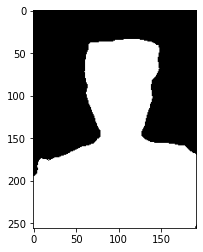

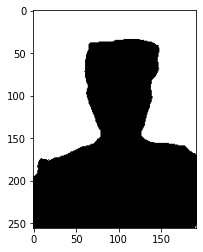

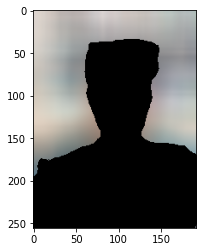

In [18]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)
plt.imshow(img_mask_color)
plt.show()
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(img_bg_mask)
plt.show()
# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!

img_bg_blur = cv2.bitwise_and(img_orig_blur , img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


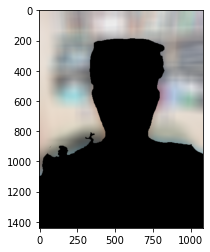 다음 이미지를 보면 의자에 걸려있는 옷도 같이 segmentation된것을 볼수 있다


In [19]:
print(img_person.shape)

(256, 192, 3)


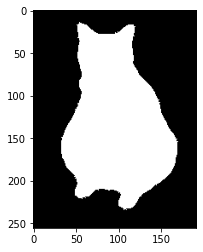

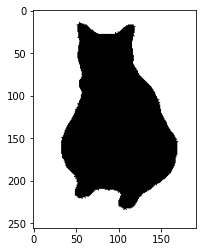

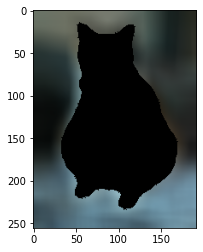

In [38]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_cat_mask_color = cv2.cvtColor(img_cat_mask, cv2.COLOR_GRAY2RGB)
plt.imshow(img_cat_mask_color)
plt.show()
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_cat_bg_mask = cv2.bitwise_not(img_cat_mask_color)
plt.imshow(img_cat_bg_mask)
plt.show()
# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!

img_cat_bg_blur = cv2.bitwise_and(img_cat_orig_blur , img_cat_bg_mask)
plt.imshow(cv2.cvtColor(img_cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

선아님의 고양이 덕순이로도 segmentation을 성공적으로 수행하게 되었다

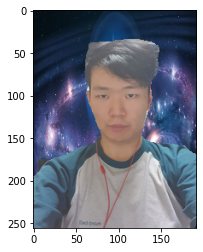

[[[ 22  15   6]
  [ 22  15   6]
  [ 22  15   6]
  ...
  [ 41  27  20]
  [ 38  24  17]
  [ 37  23  15]]

 [[ 22  15   6]
  [ 22  15   6]
  [ 22  15   6]
  ...
  [ 41  23  17]
  [ 39  21  14]
  [ 37  20  13]]

 [[ 22  15   6]
  [ 22  15   6]
  [ 22  15   6]
  ...
  [ 40  22  15]
  [ 39  21  14]
  [ 39  20  13]]

 ...

 [[154 129  97]
  [152 126  95]
  [151 125  95]
  ...
  [101  89  79]
  [104  93  82]
  [ 45  25  14]]

 [[153 127  97]
  [152 126  96]
  [152 127  97]
  ...
  [100  88  79]
  [ 85  46  38]
  [ 35  22  12]]

 [[152 126  96]
  [152 126  96]
  [151 126  95]
  ...
  [104  91  83]
  [ 70  32  24]
  [ 32  21  11]]]
<class 'numpy.ndarray'>


In [20]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_bg_rs = cv2.resize(img_bg, (192,256))
img_concat = np.where(img_mask_color==255, img_person, img_bg_rs)
img_concat2 = np.where(img_bg_mask==0, img_person, img_bg_rs)
#np.where(조건, 참일떄 값, 거짓일때 값)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat2,cv2.COLOR_BGR2RGB))
plt.show()

print(img_concat2)
print(type(img_concat2))


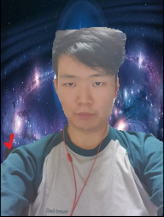 이렇게 작은 부분이 blur되지않고 나오고 있습니다

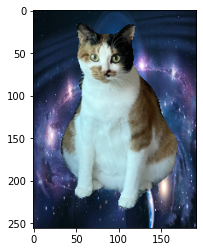

[[[ 22  15   6]
  [ 22  15   6]
  [ 22  15   6]
  ...
  [ 41  27  20]
  [ 38  24  17]
  [ 37  23  15]]

 [[ 22  15   6]
  [ 22  15   6]
  [ 22  15   6]
  ...
  [ 41  23  17]
  [ 39  21  14]
  [ 37  20  13]]

 [[ 22  15   6]
  [ 22  15   6]
  [ 22  15   6]
  ...
  [ 40  22  15]
  [ 39  21  14]
  [ 39  20  13]]

 ...

 [[ 54  31  23]
  [ 55  32  24]
  [ 58  35  27]
  ...
  [201 153 150]
  [ 97  52  45]
  [ 45  25  14]]

 [[ 54  32  21]
  [ 53  33  22]
  [ 53  33  22]
  ...
  [104  57  50]
  [ 85  46  38]
  [ 35  22  12]]

 [[ 54  32  21]
  [ 53  33  22]
  [ 50  30  19]
  ...
  [ 85  39  31]
  [ 70  32  24]
  [ 32  21  11]]]
<class 'numpy.ndarray'>


In [39]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_bg_rs = cv2.resize(img_bg, (192,256))
img_concat = np.where(img_cat_mask_color==255, img_cat, img_bg_rs)
img_concat2 = np.where(img_cat_bg_mask==0, img_cat, img_bg_rs)
#np.where(조건, 참일떄 값, 거짓일때 값)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat2,cv2.COLOR_BGR2RGB))
plt.show()

print(img_concat2)
print(type(img_concat2))

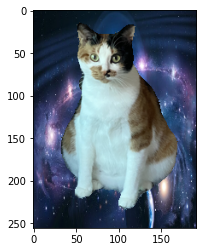 이렇게 우주에 있는 덕순이도 만들어보았습니다

Step 3. 해결 방법을 제안해 보기

기존의 이미지는 2D방식으로 받아들이기때문에, 정확히 이 물체가 어느 클래스에 속하는지 알 수 없다.

따라서 3D방식으로 변화해서, 입체적으로 살펴보고, 각 면(Dimension)에 대해서 절반 이상에 해당하는 혹은 가장 많이 해당하는 클래스를

라벨값으로 가져서 blur처리를 최종적으로 하게되는 방식으로 접근해보면 좋을 것 같다.


# 회고
이미지 편집, 블러처리, 뒷배경 입히기, 이런 다양한 기능을 수행해본 것 같다.

사람과 고양이에 대해서도 수행했고, 뒤에 우주배경도 합쳐보았다.

그런데 segementation을 통해 blur처리할 때, 의자에 걸쳐있던 옷을 블러처리 안하는 상황도 나오게 되었다. 

이런 문제점에 대한 해결방안을 제안해봤다.


